<a href="https://colab.research.google.com/github/magenta/mt3/blob/main/mt3/colab/music_transcription_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Transcription with Transformers

This notebook is an interactive demo of a few [music transcription models](g.co/magenta/mt3) created by Google's [Magenta](g.co/magenta) team.  You can upload audio and have one of our models automatically transcribe it.

<img src="https://magenta.tensorflow.org/assets/transcription-with-transformers/architecture_diagram.png" alt="Transformer-based transcription architecture">

The notebook supports two pre-trained models:
1. the piano transcription model from [our ISMIR 2021 paper](https://archives.ismir.net/ismir2021/paper/000030.pdf)
1. the multi-instrument transcription model from [our ICLR 2022 paper](https://openreview.net/pdf?id=iMSjopcOn0p)

**Caveat**: neither model is trained on singing.  If you upload audio with vocals, you will likely get weird results.  Multi-instrument transcription is still not a completely-solved problem and so you may get weird results regardless.

In any case, we hope you have fun transcribing!  Feel free to tweet any interesting output at [@GoogleMagenta](https://twitter.com/googlemagenta)...

### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Press ▶️ on the left of each cell to execute the cell
* In the __Load Model__ cell, choose either `ismir2021` for piano transcription or `mt3` for multi-instrument transcription
* In the __Upload Audio__ cell, choose an MP3 or WAV file from your computer when prompted
* Transcribe the audio using the __Transcribe Audio__ cell (it may take a few minutes depending on the length of the audio)



In [ ]:
# Copyright 2021 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

#@title Setup Environment
#@markdown Install MT3 and its dependencies (may take a few minutes).

!apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev

!pip install --upgrade pip
!pip install --upgrade jaxlib -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install nest-asyncio
!pip install pyfluidsynth

# install t5x
!git clone --branch=main https://github.com/google-research/t5x
!mv t5x t5x_tmp; mv t5x_tmp/* .; rm -r t5x_tmp
!sed -i 's:jax\[tpu\]:jax:' setup.py
!python3 -m pip install -e .

# install mt3
!git clone --branch=main https://github.com/magenta/mt3
!mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
!python3 -m pip install -e .

# copy checkpoints
!gsutil -q -m cp -r gs://mt3/checkpoints .

# copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .



Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 1.7 MB 4.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 153.1 MB 59 kB/s             
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.1.71+cuda111
    Uninstalling jaxlib-0.1.71+cuda111:
      Successfully uninstalled jaxlib-0.1.71+cuda111
Cloning into 't5x

In [ ]:
#@title Imports and Definitions

import functools
import os

import numpy as np
import tensorflow.compat.v2 as tf

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x

from mt3 import metrics_utils
from mt3 import models
from mt3 import network
from mt3 import note_sequences
from mt3 import preprocessors
from mt3 import spectrograms
from mt3 import vocabularies

from google.colab import files

import nest_asyncio
nest_asyncio.apply()

SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

def upload_audio(sample_rate):
  data = list(files.upload().values())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.audio_io.wav_data_to_samples_librosa(
    data[0], sample_rate=sample_rate)



class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    gin_files = ['/content/mt3/gin/model.gin',
                 f'/content/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length, 
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.ModelBasedPjitPartitioner(
        model_parallel_submesh=(1, 1, 1, 1), num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    """Restore training state from checkpoint, resets self._predict_fn()."""
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    """Generate a partitioned prediction function for decoding."""
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    """Predict tokens from preprocessed dataset batch."""
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    """Infer note sequence from audio samples.
    
    Args:
      audio: 1-d numpy array of audio samples (16kHz) for a single example.

    Returns:
      A note_sequence of the transcribed audio.
    """
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    """Create a TF Dataset of spectrograms from input audio."""
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    """Compute spectrogram frames from audio."""
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        # Cache occurs here during training.
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    # Round down to nearest symbolic token step.
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        # Internal MT3 code expects raw inputs, not used here.
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens



In [ ]:
#@title Load Model
#@markdown The `ismir2021` model transcribes piano only, with note velocities.
#@markdown The `mt3` model transcribes multiple simultaneous instruments,
#@markdown but without velocities.

MODEL = "ismir2021" #@param["ismir2021", "mt3"]

checkpoint_path = f'/content/checkpoints/{MODEL}/'

inference_model = InferenceModel(checkpoint_path, MODEL)


/usr/local/lib/python3.7/dist-packages/jax/experimental/pjit.py:180: UserWarning: pjit is an experimental feature and probably has bugs!
  warn("pjit is an experimental feature and probably has bugs!")
/usr/local/lib/python3.7/dist-packages/jax/_src/lib/xla_bridge.py:427: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "


In [ ]:
#@title Upload Audio

audio = upload_audio(sample_rate=SAMPLE_RATE)
note_seq.notebook_utils.colab_play(audio, sample_rate=SAMPLE_RATE)

Saving GMajor_Good.wav to GMajor_Good.wav


In [ ]:
#@title Transcribe Audio
#@markdown This may take a few minutes depending on the length of the audio file
#@markdown you uploaded.

est_ns = inference_model(audio)

note_seq.play_sequence(est_ns, synth=note_seq.fluidsynth, 
                       sample_rate=SAMPLE_RATE, sf2_path=SF2_PATH)
note_seq.plot_sequence(est_ns)
#note_seq.plot_sequence(sequence_prediction)


In [ ]:
# import numpy as np
# "SEQUENCE-TO-SEQUENCE PIANO TRANSCRIPTION WITH TRANSFORMERS".lower()

'sequence-to-sequence piano transcription with transformers'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Download MIDI Transcription

note_seq.sequence_proto_to_midi_file(est_ns, '/content/gdrive/MyDrive/AMT/ArtificialDataset/GMajor_Good.mid')
#files.download('/content/gdrive/MyDrive/AMT/YamahaA1.mid')

Now we have a midi file there, lets try to open it using music21 library, which seems to be a robust platform to explore music files and music theory.



In [ ]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

# Some helper methods.    
def concat_path(path, child):
    return path + "/" + child

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(concat_path('/content/gdrive/MyDrive/AMT/ArtificialDataset/', "BMajor_Good.mid"), True)
base_midi

<music21.stream.Score 0x7f124dc15f10>

In [ ]:
#library for understanding music
from music21 import *
import numpy as np
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)

    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:

        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 

            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note`
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                # #chord
                # elif isinstance(element, chord.Chord):
                #     notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [ ]:
read_midi('/content/gdrive/MyDrive/AMT/ArtificialDataset/CMajor_Good.mid')

Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/CMajor_Good.mid


array(['C4', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'G2', 'B4', 'C5', 'C5',
       'B4', 'A4', 'G4', 'E4', 'D4', 'C4'], dtype='<U2')

In [ ]:
print(list(set(read_midi('/content/gdrive/MyDrive/AMT/ArtificialDataset/EMajor_Good.mid'))))

Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/EMajor_Good.mid
['B4', 'F#1', 'D3', 'F#2', 'A4', 'E5', 'G#4', 'B1', 'G#5', 'C#5', 'F#4', 'F2', 'E4', 'G#2', 'E-5']


In [ ]:
import os
path='/content/gdrive/MyDrive/AMT/ArtificialDataset/'

files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/A#Major_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/A#Major_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/AMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/AMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/BMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/BMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/C#Major_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/C#Major_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/CMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/CMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/D#Major_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/D#Major_Good.mid
Loading Music Fi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
print(notes_array) # List of numpy arrays

[array(['B-4', 'B-4', 'C5', 'A1', 'C#5', 'E-5', 'F5', 'G5', 'A5', 'B-5',
       'B-5', 'A5', 'G5', 'F5', 'F2', 'E-5', 'C#5', 'C5'], dtype='<U3')
 array(['B-4', 'C5', 'D5', 'E-2', 'E-5', 'F5', 'G5', 'A5', 'B-5', 'B-5',
       'A5', 'G5', 'F5', 'E-5', 'D5', 'C5'], dtype='<U3')
 array(['F#2', 'A4', 'B4', 'A1', 'C#5', 'E-5', 'E5', 'B1', 'F#5', 'G#5',
       'A5', 'A5', 'G#5', 'F#5', 'F#5', 'E5', 'E-5', 'C#5', 'B4'],
      dtype='<U3')
 array(['B1', 'A4', 'B4', 'F1', 'C#5', 'D5', 'F#1', 'E5', 'B1', 'F#5',
       'G#5', 'A5', 'A5', 'G#5', 'F#5', 'E5', 'E2', 'D5', 'A1', 'C#5',
       'G#1', 'B4', 'A1', 'A4'], dtype='<U3')
 array(['B4', 'G2', 'B4', 'C#5', 'F2', 'E-5', 'F5', 'F#5', 'G#5', 'B-5',
       'C6', 'C6', 'B-5', 'G#5', 'F#5', 'E5', 'F2', 'E-5', 'B-1', 'C#5'],
      dtype='<U3')
 array(['G2', 'B4', 'C#5', 'C#5', 'E-5', 'E5', 'C#5', 'F#5', 'C#5', 'G#5',
       'B-5', 'B5', 'B5', 'B-5', 'G#5', 'F#5', 'E5', 'E-5'], dtype='<U3')
 array(['C#4', 'E-4', 'F#4', 'G#4', 'B-4', 'C5', 'F#1', 'C#5',

In [ ]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))
print(unique_notes)

42
['A1', 'E5', 'B1', 'C#4', 'F4', 'F#5', 'E-5', 'B4', 'E3', 'E-4', 'C5', 'C4', 'A4', 'F1', 'E2', 'A5', 'G4', 'D4', 'F#4', 'D3', 'F#1', 'F#2', 'D5', 'B-4', 'E-2', 'C#5', 'G#1', 'C6', 'F2', 'E4', 'B5', 'G#2', 'F5', 'G5', 'A2', 'B-1', 'B-5', 'G#4', 'G2', 'G#5', 'D2', 'E-3']


In [ ]:
#unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_notes))
import pprint
pprint.pprint(x_note_to_int)

{'A1': 0,
 'A2': 34,
 'A4': 12,
 'A5': 15,
 'B-1': 35,
 'B-4': 23,
 'B-5': 36,
 'B1': 2,
 'B4': 7,
 'B5': 30,
 'C#4': 3,
 'C#5': 25,
 'C4': 11,
 'C5': 10,
 'C6': 27,
 'D2': 40,
 'D3': 19,
 'D4': 17,
 'D5': 22,
 'E-2': 24,
 'E-3': 41,
 'E-4': 9,
 'E-5': 6,
 'E2': 14,
 'E3': 8,
 'E4': 29,
 'E5': 1,
 'F#1': 20,
 'F#2': 21,
 'F#4': 18,
 'F#5': 5,
 'F1': 13,
 'F2': 28,
 'F4': 4,
 'F5': 32,
 'G#1': 26,
 'G#2': 31,
 'G#4': 37,
 'G#5': 39,
 'G2': 38,
 'G4': 16,
 'G5': 33}


In [ ]:
import os
path='/content/gdrive/MyDrive/AMT/ArtificialDataset/'

files=[i for i in os.listdir(path) if i.endswith("_Good.mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/A#Major_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/AMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/BMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/C#Major_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/CMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/D#Major_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/DMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/EMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/F#Major_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/FMajor_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/G#Major_Good.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/GMajor_Good.mid


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
print((notes_array))

[array(['B-4', 'C5', 'D5', 'E-2', 'E-5', 'F5', 'G5', 'A5', 'B-5', 'B-5',
       'A5', 'G5', 'F5', 'E-5', 'D5', 'C5'], dtype='<U3')
 array(['B1', 'A4', 'B4', 'F1', 'C#5', 'D5', 'F#1', 'E5', 'B1', 'F#5',
       'G#5', 'A5', 'A5', 'G#5', 'F#5', 'E5', 'E2', 'D5', 'A1', 'C#5',
       'G#1', 'B4', 'A1', 'A4'], dtype='<U3')
 array(['G2', 'B4', 'C#5', 'C#5', 'E-5', 'E5', 'C#5', 'F#5', 'C#5', 'G#5',
       'B-5', 'B5', 'B5', 'B-5', 'G#5', 'F#5', 'E5', 'E-5'], dtype='<U3')
 array(['C#4', 'E-4', 'F4', 'F#4', 'G#4', 'G#5', 'B-4', 'C5', 'F1', 'C#5',
       'F1', 'C#5', 'C5', 'B-4', 'F#4', 'C#4'], dtype='<U3')
 array(['C4', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'G2', 'B4', 'C5', 'C5',
       'B4', 'A4', 'G4', 'E4', 'D4', 'C4'], dtype='<U2')
 array(['E-4', 'F4', 'F5', 'G4', 'B-4', 'C5', 'D5', 'E-5', 'F2', 'E-5',
       'D5', 'C5', 'B-4', 'B-4', 'G#4', 'G4'], dtype='<U3')
 array(['D4', 'E4', 'E4', 'F#4', 'G4', 'A4', 'G2', 'B4', 'F#2', 'C#5',
       'C#5', 'D5', 'A1', 'D5', 'A1', 'C#5', 'B4', 'A4', 'G4',

In [ ]:
df = pd.DataFrame(list(map(np.ravel, notes_array)))

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,B-4,C5,D5,E-2,E-5,F5,G5,A5,B-5,B-5,A5,G5,F5,E-5,D5,C5,None,None,None,None,None,None,None,None
1,B1,A4,B4,F1,C#5,D5,F#1,E5,B1,F#5,G#5,A5,A5,G#5,F#5,E5,E2,D5,A1,C#5,G#1,B4,A1,A4
2,G2,B4,C#5,C#5,E-5,E5,C#5,F#5,C#5,G#5,B-5,B5,B5,B-5,G#5,F#5,E5,E-5,None,None,None,None,None,None
3,C#4,E-4,F4,F#4,G#4,G#5,B-4,C5,F1,C#5,F1,C#5,C5,B-4,F#4,C#4,None,None,None,None,None,None,None,None
4,C4,C4,D4,E4,F4,G4,A4,G2,B4,C5,C5,B4,A4,G4,E4,D4,C4,None,None,None,None,None,None,None
5,E-4,F4,F5,G4,B-4,C5,D5,E-5,F2,E-5,D5,C5,B-4,B-4,G#4,G4,None,None,None,None,None,None,None,None
6,D4,E4,E4,F#4,G4,A4,G2,B4,F#2,C#5,C#5,D5,A1,D5,A1,C#5,B4,A4,G4,F#4,E4,D4,None,None
7,E4,E4,F#4,G#4,G#5,A4,G#2,B4,B1,C#5,E-5,F#2,E5,F#2,E5,F2,E-5,F2,C#5,F#1,A4,G#4,D3,F#4
8,F#4,G#4,B-4,B4,F#1,C#5,F1,E-5,F5,F#5,D3,F#5,F5,E-5,C#5,B4,B-4,G#4,None,None,None,None,None,None
9,F4,F5,G4,A4,G4,B-4,C5,D5,F#2,E5,F#2,F5,G2,F5,E5,A2,D5,D2,C5,B1,A4,G4,None,None


In [ ]:
df['Label'] = 1

In [ ]:
import os
path='/content/gdrive/MyDrive/AMT/ArtificialDataset/'

files=[i for i in os.listdir(path) if i.endswith("_Bad.mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/A#Major_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/AMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/BMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/C#Major_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/CMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/D#Major_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/DMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/EMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/F#Major_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/FMajor_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/G#Major_Bad.mid
Loading Music File: /content/gdrive/MyDrive/AMT/ArtificialDataset/GMajor_Bad.mid


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
df = df.append(pd.DataFrame(list(map(np.ravel, notes_array))))

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Label
0,B-4,C5,D5,E-2,E-5,F5,G5,A5,B-5,B-5,A5,G5,F5,E-5,D5,C5,None,None,None,None,None,None,None,None,1.0
1,B1,A4,B4,F1,C#5,D5,F#1,E5,B1,F#5,G#5,A5,A5,G#5,F#5,E5,E2,D5,A1,C#5,G#1,B4,A1,A4,1.0
2,G2,B4,C#5,C#5,E-5,E5,C#5,F#5,C#5,G#5,B-5,B5,B5,B-5,G#5,F#5,E5,E-5,None,None,None,None,None,None,1.0
3,C#4,E-4,F4,F#4,G#4,G#5,B-4,C5,F1,C#5,F1,C#5,C5,B-4,F#4,C#4,None,None,None,None,None,None,None,None,1.0
4,C4,C4,D4,E4,F4,G4,A4,G2,B4,C5,C5,B4,A4,G4,E4,D4,C4,None,None,None,None,None,None,None,1.0
5,E-4,F4,F5,G4,B-4,C5,D5,E-5,F2,E-5,D5,C5,B-4,B-4,G#4,G4,None,None,None,None,None,None,None,None,1.0
6,D4,E4,E4,F#4,G4,A4,G2,B4,F#2,C#5,C#5,D5,A1,D5,A1,C#5,B4,A4,G4,F#4,E4,D4,None,None,1.0
7,E4,E4,F#4,G#4,G#5,A4,G#2,B4,B1,C#5,E-5,F#2,E5,F#2,E5,F2,E-5,F2,C#5,F#1,A4,G#4,D3,F#4,1.0
8,F#4,G#4,B-4,B4,F#1,C#5,F1,E-5,F5,F#5,D3,F#5,F5,E-5,C#5,B4,B-4,G#4,None,None,None,None,None,None,1.0
9,F4,F5,G4,A4,G4,B-4,C5,D5,F#2,E5,F#2,F5,G2,F5,E5,A2,D5,D2,C5,B1,A4,G4,None,None,1.0


In [ ]:
df.replace(np.nan,0,inplace=True)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Label
0,B-4,C5,D5,E-2,E-5,F5,G5,A5,B-5,B-5,A5,G5,F5,E-5,D5,C5,0,0,0,0,0,0,0,0,1.0
1,B1,A4,B4,F1,C#5,D5,F#1,E5,B1,F#5,G#5,A5,A5,G#5,F#5,E5,E2,D5,A1,C#5,G#1,B4,A1,A4,1.0
2,G2,B4,C#5,C#5,E-5,E5,C#5,F#5,C#5,G#5,B-5,B5,B5,B-5,G#5,F#5,E5,E-5,0,0,0,0,0,0,1.0
3,C#4,E-4,F4,F#4,G#4,G#5,B-4,C5,F1,C#5,F1,C#5,C5,B-4,F#4,C#4,0,0,0,0,0,0,0,0,1.0
4,C4,C4,D4,E4,F4,G4,A4,G2,B4,C5,C5,B4,A4,G4,E4,D4,C4,0,0,0,0,0,0,0,1.0
5,E-4,F4,F5,G4,B-4,C5,D5,E-5,F2,E-5,D5,C5,B-4,B-4,G#4,G4,0,0,0,0,0,0,0,0,1.0
6,D4,E4,E4,F#4,G4,A4,G2,B4,F#2,C#5,C#5,D5,A1,D5,A1,C#5,B4,A4,G4,F#4,E4,D4,0,0,1.0
7,E4,E4,F#4,G#4,G#5,A4,G#2,B4,B1,C#5,E-5,F#2,E5,F#2,E5,F2,E-5,F2,C#5,F#1,A4,G#4,D3,F#4,1.0
8,F#4,G#4,B-4,B4,F#1,C#5,F1,E-5,F5,F#5,D3,F#5,F5,E-5,C#5,B4,B-4,G#4,0,0,0,0,0,0,1.0
9,F4,F5,G4,A4,G4,B-4,C5,D5,F#2,E5,F#2,F5,G2,F5,E5,A2,D5,D2,C5,B1,A4,G4,0,0,1.0


In [ ]:
x_note_to_int[1.0]=1
x_note_to_int[0.0]=0

In [ ]:
df = df.apply(lambda x:x.map(x_note_to_int))

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Label
0,23,10,22,24,6,32,33,15,36,36,15,33,32,6,22,10,0,0,0,0,0,0,0,0,1
1,2,12,7,13,25,22,20,1,2,5,39,15,15,39,5,1,14,22,0,25,26,7,0,12,1
2,38,7,25,25,6,1,25,5,25,39,36,30,30,36,39,5,1,6,0,0,0,0,0,0,1
3,3,9,4,18,37,39,23,10,13,25,13,25,10,23,18,3,0,0,0,0,0,0,0,0,1
4,11,11,17,29,4,16,12,38,7,10,10,7,12,16,29,17,11,0,0,0,0,0,0,0,1
5,9,4,32,16,23,10,22,6,28,6,22,10,23,23,37,16,0,0,0,0,0,0,0,0,1
6,17,29,29,18,16,12,38,7,21,25,25,22,0,22,0,25,7,12,16,18,29,17,0,0,1
7,29,29,18,37,39,12,31,7,2,25,6,21,1,21,1,28,6,28,25,20,12,37,19,18,1
8,18,37,23,7,20,25,13,6,32,5,19,5,32,6,25,7,23,37,0,0,0,0,0,0,1
9,4,32,16,12,16,23,10,22,21,1,21,32,38,32,1,34,22,40,10,2,12,16,0,0,1


In [ ]:
df.reset_index(inplace=True)

In [ ]:
df

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Label
0,0,23,10,22,24,6,32,33,15,36,36,15,33,32,6,22,10,0,0,0,0,0,0,0,0,1
1,1,2,12,7,13,25,22,20,1,2,5,39,15,15,39,5,1,14,22,0,25,26,7,0,12,1
2,2,38,7,25,25,6,1,25,5,25,39,36,30,30,36,39,5,1,6,0,0,0,0,0,0,1
3,3,3,9,4,18,37,39,23,10,13,25,13,25,10,23,18,3,0,0,0,0,0,0,0,0,1
4,4,11,11,17,29,4,16,12,38,7,10,10,7,12,16,29,17,11,0,0,0,0,0,0,0,1
5,5,9,4,32,16,23,10,22,6,28,6,22,10,23,23,37,16,0,0,0,0,0,0,0,0,1
6,6,17,29,29,18,16,12,38,7,21,25,25,22,0,22,0,25,7,12,16,18,29,17,0,0,1
7,7,29,29,18,37,39,12,31,7,2,25,6,21,1,21,1,28,6,28,25,20,12,37,19,18,1
8,8,18,37,23,7,20,25,13,6,32,5,19,5,32,6,25,7,23,37,0,0,0,0,0,0,1
9,9,4,32,16,12,16,23,10,22,21,1,21,32,38,32,1,34,22,40,10,2,12,16,0,0,1


In [ ]:
# pip install mido

     |████████████████████████████████| 51 kB 3.0 MB/s 


In [ ]:
# import mido
# mid = mido.MidiFile('/content/gdrive/MyDrive/AMT/ArtificialDataset/CMajor_Good.mid', clip=True)
# mid.tracks    # 84,86,88 notes correspond to C6,D6,E6 respectively.

[MidiTrack([
  MetaMessage('set_tempo', tempo=500000, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('end_of_track', time=1)]),
 MidiTrack([
  Message('program_change', channel=0, program=0, time=0),
  Message('note_on', channel=0, note=60, velocity=78, time=84),
  Message('note_on', channel=0, note=60, velocity=0, time=145),
  Message('note_on', channel=0, note=60, velocity=82, time=0),
  Message('note_on', channel=0, note=62, velocity=78, time=237),
  Message('note_on', channel=0, note=60, velocity=0, time=256),
  Message('note_on', channel=0, note=64, velocity=81, time=4),
  Message('note_on', channel=0, note=62, velocity=0, time=13),
  Message('note_on', channel=0, note=65, velocity=67, time=242),
  Message('note_on', channel=0, note=67, velocity=78, time=269),
  Message('note_on', channel=0, note=64, velocity=0, time=13),
  Message('note_on', channel=0, note=69, velocity=78, time=242),

# **Debugging MIDI data**
We can start listing the instruments used on that music:

In [ ]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
Piano


Check the following plot with notes as if we are using a DAW displaying the composition on the piano roll:

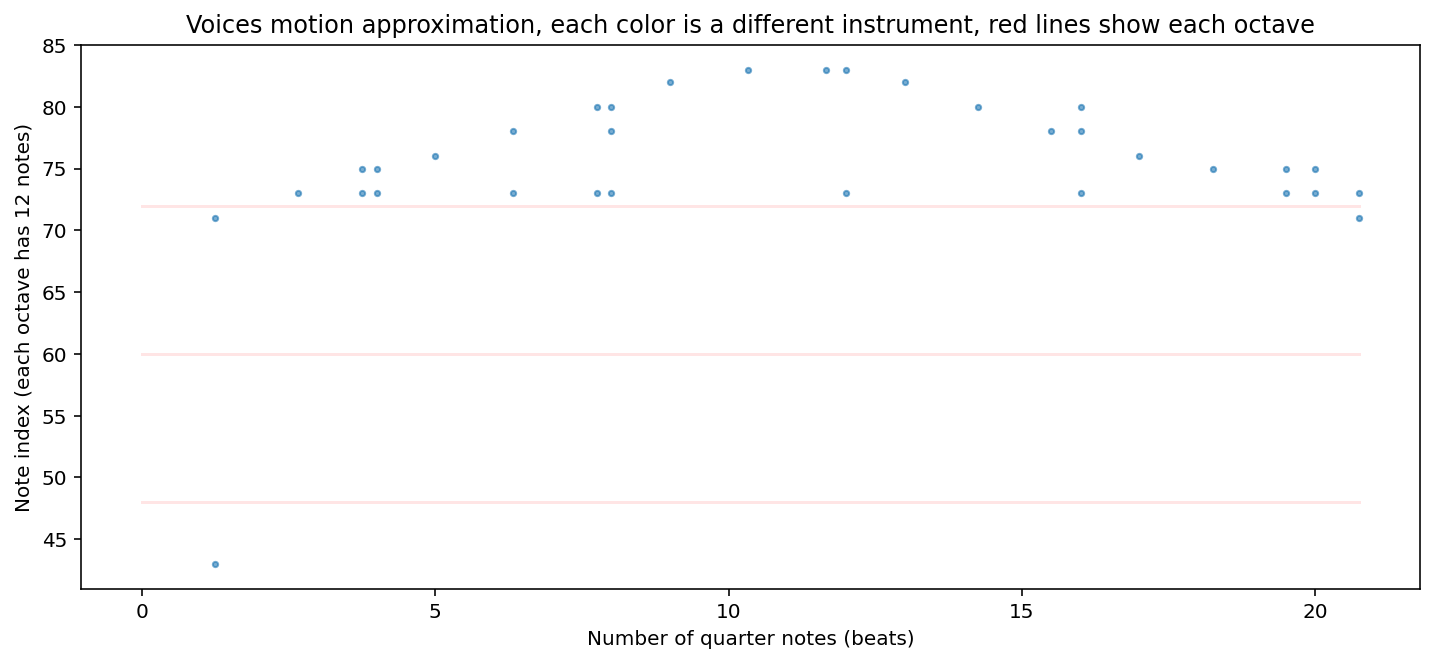

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

We can take a look on the pitch histogram to see which notes are more used. If you know a bit of music theory, you'll notice that the seven more used notes are part of G-major, so this would be a good way to guess the music's key.

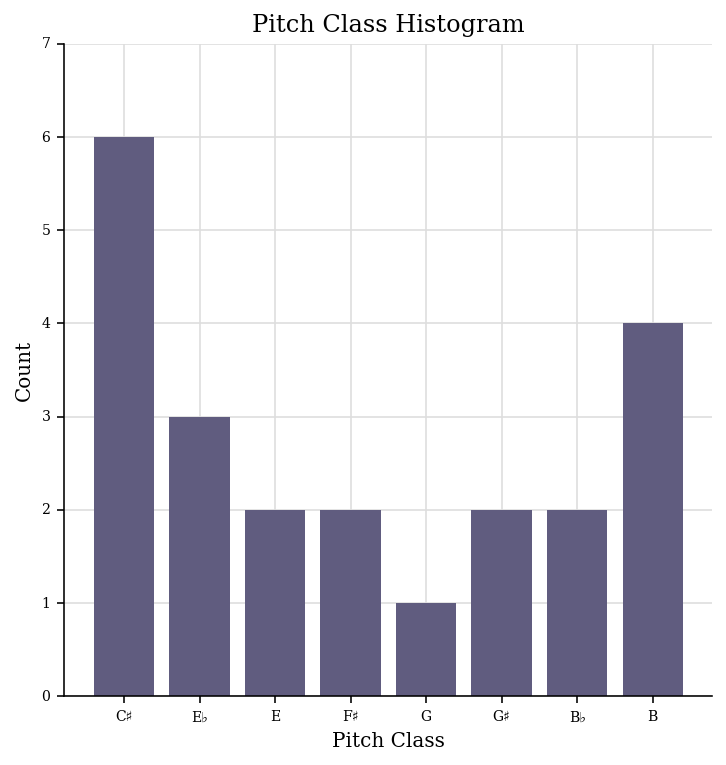

In [ ]:
base_midi.plot('histogram', 'pitchClass', 'count')

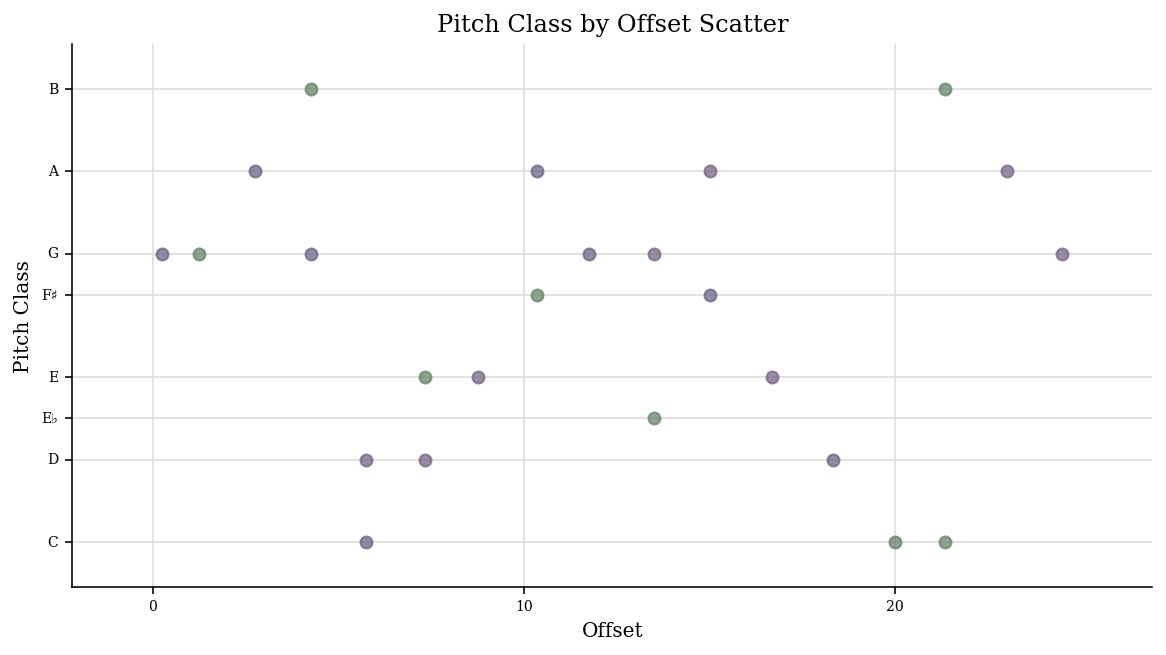

In [ ]:
base_midi.plot('scatter', 'offset', 'pitchClass')

After seeing those graphics, we can be more confident in analyzing that music, lets take a look on some extra composition parameters:



In [ ]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: F# major
Music key confidence: 0.7351066544998388
Other music key alternatives:
c# minor
g# minor
B major
f# minor


In [ ]:
# from multiprocessing.dummy import Pool as ThreadPool # Use this when IO is the problem
from multiprocessing import Pool # Use this when CPU-intensive functions are the problem.
import pandas as pd
import os
# Go get a coffee, this cell takes hours to run...

def get_file_name(link):
    filename = link.split('/')[::-1][0]
    print(filename)
    return filename

def process_single_file(midi_param):
  print('Inside process_single_file')
  #print(midi_param)
  # print(midi_param[0])
  try:
      midi_path = midi_param[0]

      midi_name = get_file_name(midi_param[1])
      # print(midi_path)
      midi = open_midi(midi_param[1], True)
      return (
          midi.analyze('key'),
          midi_name)
  except Exception as e:
      print("Error on {0}".format(midi_name))
      print(e)
      return None

def create_midi_dataframe(folder_path):
    key_signature_column = []
    game_name_column = []
    harmonic_reduction_column = []
    midi_name_column = []
    pool = Pool(8)
    midi_params = []
    # for key, value in target_games.items():
    #     folder_path = concat_path(sonic_path, key)
    for midi_name in os.listdir(folder_path):
      #print(midi_name)
      midi_params.append((folder_path,concat_path(folder_path, midi_name)))
    #print(midi_params)
    results = pool.map(process_single_file, midi_params)
    for result in results:
        if (result is None):
            continue
            
        key_signature_column.append(result[0])
        # game_name_column.append(result[1])
        # harmonic_reduction_column.append(result[2])
        midi_name_column.append(result[1])
    
    d = {'midi_name': midi_name_column,
         #'game_name': game_name_column,
         'key_signature' : key_signature_column,
         #'harmonic_reduction': harmonic_reduction_column
         }
    return pd.DataFrame(data=d)

folder_path = '/content/gdrive/MyDrive/AMT/ArtificialDataset'
sonic_df = create_midi_dataframe(folder_path)

Inside process_single_file
Inside process_single_file
Inside process_single_file
Inside process_single_file
Inside process_single_file
Inside process_single_file
Inside process_single_file
C#Major_Good.mid
A#Major_Good.mid
AMajor_Bad.mid
A#Major_Bad.mid
C#Major_Bad.mid
AMajor_Good.mid
BMajor_Good.mid
BMajor_Bad.mid
Inside process_single_file
Inside process_single_file
CMajor_Bad.mid
Inside process_single_file
CMajor_Good.mid
Inside process_single_file
D#Major_Bad.mid
Inside process_single_file
D#Major_Good.mid
Inside process_single_file
DMajor_Bad.mid
Inside process_single_file
DMajor_Good.mid
Inside process_single_file
EMajor_Bad.mid
Inside process_single_file
EMajor_Good.mid
Inside process_single_file
F#Major_Bad.mid
Inside process_single_file
F#Major_Good.mid
Inside process_single_file
FMajor_Bad.mid
Inside process_single_file
FMajor_Good.mid
Inside process_single_file
G#Major_Bad.mid
Inside process_single_file
G#Major_Good.mid
Inside process_single_file
GMajor_Bad.mid
Inside proces

In [ ]:
sonic_df

,midi_name,key_signature
0,A#Major_Bad.mid,E- major
1,A#Major_Good.mid,g minor
2,AMajor_Bad.mid,c# minor
3,AMajor_Good.mid,D major
4,BMajor_Bad.mid,A- major
5,BMajor_Good.mid,F# major
6,C#Major_Bad.mid,C# major
7,C#Major_Good.mid,C# major
8,CMajor_Bad.mid,F major
9,CMajor_Good.mid,C major


In [ ]:
import miditapyr
mf = miditapyr.MidiFrames('/content/gdrive/MyDrive/AMT/ArtificialDataset/GMajor_Good.mid')

In [ ]:
mf.midi_frame_unnested.df

,i_track,meta,type,tempo,time,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,program,channel,note,velocity
0,0,True,set_tempo,500000.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,True,time_signature,NaN,0,4.0,4.0,24.0,8.0,NaN,NaN,NaN,NaN
2,0,True,end_of_track,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,False,program_change,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,1,False,note_on,NaN,31,NaN,NaN,NaN,NaN,NaN,0.0,67.0,83.0
5,1,False,note_on,NaN,220,NaN,NaN,NaN,NaN,NaN,0.0,67.0,0.0
6,1,False,note_on,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,67.0,88.0
7,1,False,note_on,NaN,356,NaN,NaN,NaN,NaN,NaN,0.0,69.0,78.0
8,1,False,note_on,NaN,326,NaN,NaN,NaN,NaN,NaN,0.0,43.0,48.0
9,1,False,note_on,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,71.0,84.0


The scatter plot shows that the use of notes look consistent through time, so there are no key changes in this piece.



In [ ]:
import mido
mid = mido.MidiFile('/content/gdrive/MyDrive/AMT/YamahaA1.mid', clip=True)
mid.tracks    # 84,86,88 notes correspond to C6,D6,E6 respectively.

[MidiTrack([
  MetaMessage('set_tempo', tempo=500000, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('end_of_track', time=1)]),
 MidiTrack([
  Message('program_change', channel=0, program=0, time=0),
  Message('note_on', channel=0, note=30, velocity=46, time=40),
  Message('note_on', channel=0, note=84, velocity=86, time=4),
  Message('note_on', channel=0, note=30, velocity=0, time=18),
  Message('note_on', channel=0, note=43, velocity=44, time=576),
  Message('note_on', channel=0, note=86, velocity=87, time=0),
  Message('note_on', channel=0, note=31, velocity=29, time=4),
  Message('note_on', channel=0, note=43, velocity=0, time=18),
  Message('note_on', channel=0, note=31, velocity=0, time=4),
  Message('note_on', channel=0, note=84, velocity=0, time=0),
  Message('note_on', channel=0, note=30, velocity=47, time=621),
  Message('note_on', channel=0, note=88, velocity=87, time=4),
  Messa

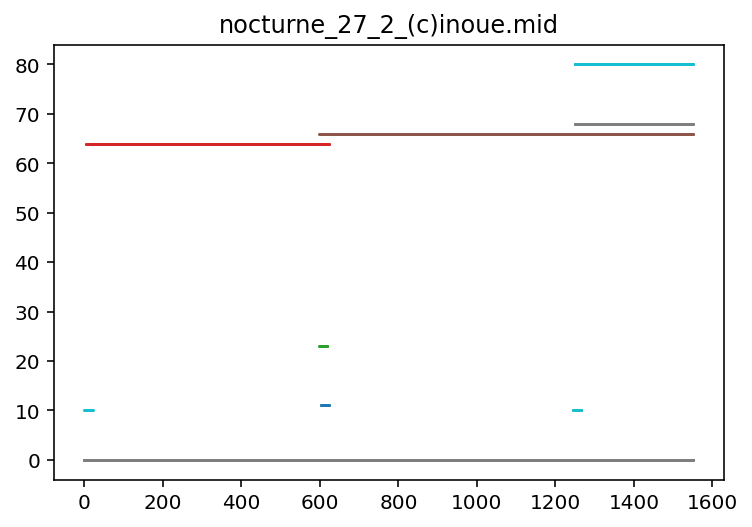

(1552, 88)



In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import string
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result


def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result


def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]


result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("nocturne_27_2_(c)inoue.mid")
plt.show()
print(result_array.shape)
print()
#print(result_array)

In [ ]:
def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [ ]:
mid_new = arry2mid(result_array, 545455)
mid_new.save('mid_newC6D6E6.mid')

In [ ]:
%pwd

In [ ]:
from google.colab import files
files.download('/content/mid_newC6D6E6.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch


def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi('/content/mid_newC6D6E6.mid', True)
base_midi

List of instruments found on MIDI file:
None


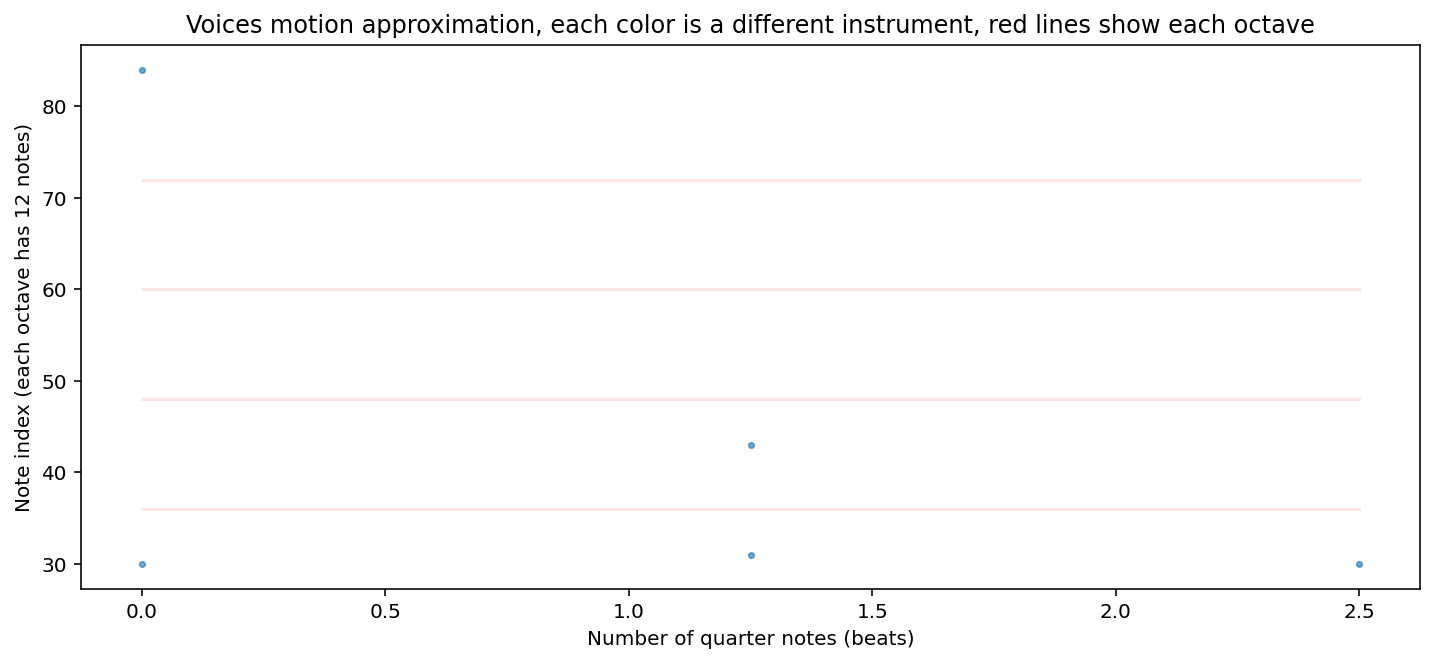

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

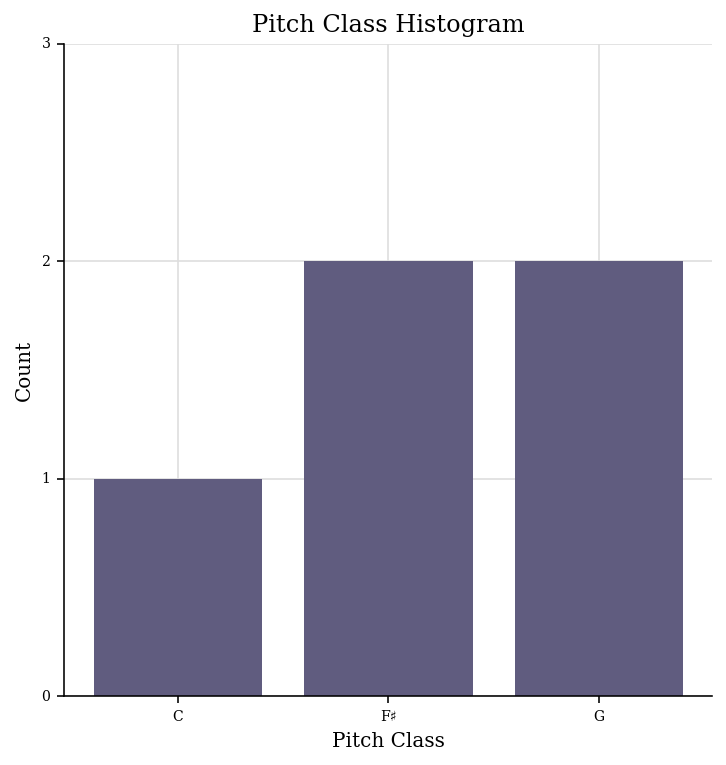

In [ ]:
base_midi.plot('histogram', 'pitchClass', 'count')


In [ ]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)


Music time signature: 4/4
Expected music key: F major
Music key confidence: 0.5056038789721222
Other music key alternatives:


# **Pretty MIDI Piano roll**
When we have a NoteSequence, either from defining it by hand or by getting it from the output of a model, we can transform them back and forth to another format called Pretty MIDI, which is a well-known library used to handle MIDI data in Python.

Let convert from NoteSequence to Pretty MIDI:



In [ ]:
from note_seq.midi_io import note_sequence_to_pretty_midi
pm = note_sequence_to_pretty_midi(est_ns)

Great! Now we can plot our sequence as a piano roll using Visual MIDI:

https://alexandredubreuil.com/publications/2020-09-13-introducing-visual-midi-for-pianoroll-visualization/

In [ ]:
pip install visual_midi

In [ ]:
from pretty_midi import PrettyMIDI
from visual_midi import Plotter

plotter = Plotter()
plotter.show(pm, "/tmp/example-01.html")

Column(id='1312', ...)

In [ ]:
# pip install MuseScore 

In [ ]:
# import os
# import music21 as m21

# us = m21.environment.UserSettings()
# us_path = us.getSettingsPath()
# if not os.path.exists(us_path):
#     us.create()
# print('Path to music21 environment', us_path)
# print(us)

In [ ]:
# # enables music21 to render images of musical notes
# print('installing lilypond...')
# !apt-get install lilypond > /dev/null

# # converts midi files to wav files into order to play them
# print('installing fluidsynth...')
# !apt-get install fluidsynth > /dev/null
# !cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

# print('done!')

In [ ]:
# !fluidsynth --version

In [ ]:
# !lilypond --version

In [ ]:
# import music21
# from IPython.display import Image, Audio

In [ ]:
# music21.__version__

In [ ]:
# def show(music):
#   display(Image(str(music.write('lily.png'))))

In [ ]:
# n = music21.note.Note('D#3')
# n.duration.type = 'half'
# show(n)

In [ ]:
# us['lilypondPath'] = '/usr/bin/lilypond'

In [ ]:
# from music21 import converter, instrument, note, chord, stream, midi

In [ ]:
# !midi2ly '/content/mid_newC6D6E6.mid'

In [ ]:
!pip install --upgrade music21

     |████████████████████████████████| 19.2 MB 12.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for music21: filename=music21-7.1.0-py3-none-any.whl size=21912607 sha256=bc0fe1c18f27a1795478c2f3890486bd6846d216c601eb7e193b9f675d5e8920
  Stored in directory: /root/.cache/pip/wheels/98/3c/67/9e30a8a4c3ac934068c95d2c27e38e1b5e5016a9257dbbf5d0
Successfully built music21
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bioni

In [ ]:
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 64 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 2s (404 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 156202 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'
us['graphicsPath'] = '/usr/bin/mscore'

# music21 is Open Source under the BSD License
# Copyright (c) 2006-20 Michael Scott Cuthbert and cuthbertLab
# Support music21 by citing it in your research:
# Cuthbert, Michael Scott.  _music21: a Toolkit for Computer-Aided Music Research_, http://web.mit.edu/music21. 2006-20.

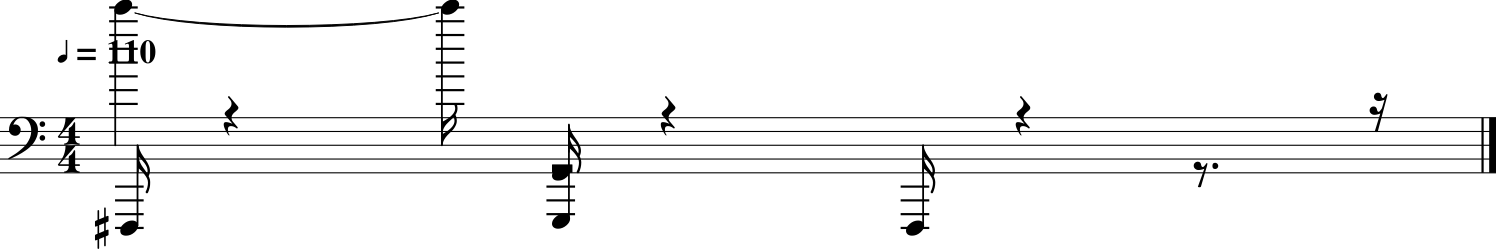

In [ ]:
import music21
parsed = music21.converter.parse('/content/mid_newC6D6E6.mid')
parsed.show()

In [ ]:
from music21 import *
n = note.Note('C#5')
n.show()

SubConverterFileIOException: ignored

In [ ]:
from music21 import *
n = note.Note('E')
n.show()

In [ ]:
print(us)

In [ ]:
!python -m music21.configure

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'music21.configure' found in sys.modules after import of package 'music21', but prior to execution of 'music21.configure'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))

______________________________________________________________________________ 
  
Welcome the music21 Configuration Assistant. You will be guided through a 
number of questions to install and setup music21. Simply pressing return at a 
prompt will select a default, if available. 

You may run this configuration again at a later time by running 
music21/configure.py. 
  
______________________________________________________________________________ 
  
Would you like to install music21 in the normal place for Python packages 
(i.e., site-packages)? Enter Yes or No (default is Yes): yes

You must authorize writing in the following directory: 
/usr/lib/python3/dist-packages 
  
Please provide your user password to complete this operation. 

running

# **Measuring the Reliability of MIDI-Derived Annotations**


In [ ]:
pip install vamp

     |████████████████████████████████| 107 kB 3.9 MB/s 
  Created wheel for vamp: filename=vamp-1.1.0-cp37-cp37m-linux_x86_64.whl size=1194715 sha256=8b0a0f9c36db6d5dde9098b7bc35354a7ef6228f4501f49e943ecc851520dde0
  Stored in directory: /root/.cache/pip/wheels/0e/07/2c/5a38d3048f33ae57d882fb385b4395d7ca4cee212f43da8c13
Successfully built vamp


In [ ]:
pip install djitw

ERROR: Could not find a version that satisfies the requirement djitw (from versions: none)
ERROR: No matching distribution found for djitw


In [ ]:
pip install mir_eval

     |████████████████████████████████| 87 kB 3.4 MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-py3-none-any.whl size=96515 sha256=a8cdb91d70e09ff1523535d90a6564b7a3797fad6dae62dccd1408057197e547
  Stored in directory: /root/.cache/pip/wheels/08/28/2d/006dbad29550bac8daf049ff34fa882655a7d3e77f3b67595e
Successfully built mir-eval


In [ ]:
pip install pretty_midi

     |████████████████████████████████| 5.6 MB 4.0 MB/s 
     |████████████████████████████████| 51 kB 8.2 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=2487f08d5ed9de8055d4dc4607c8276e65f4f71eb0aaacb1fa9d63f4c8ab44f6
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
import mir_eval
import glob
import pretty_midi
import numpy as np
import collections
import os
import librosa
import vamp
import tabulate
import djitw
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.5)


In [ ]:
%cd /content/gdrive/MyDrive/AMT/djitw-master

/content/gdrive/MyDrive/AMT/djitw-master


In [ ]:
%ls

build/  dist/  djitw/  djitw.egg-info/  setup.py


In [ ]:
!python setup.py --help

Common commands: (see '--help-commands' for more)

  setup.py build      will build the package underneath 'build/'
  setup.py install    will install the package

Global options:
  --verbose (-v)      run verbosely (default)
  --quiet (-q)        run quietly (turns verbosity off)
  --dry-run (-n)      don't actually do anything
  --help (-h)         show detailed help message
  --no-user-cfg       ignore pydistutils.cfg in your home directory
  --command-packages  list of packages that provide distutils commands

Information display options (just display information, ignore any commands)
  --help-commands     list all available commands
  --name              print package name
  --version (-V)      print package version
  --fullname          print <package name>-<version>
  --author            print the author's name
  --author-email      print the author's email address
  --maintainer        print the maintainer's name
  --maintainer-email  print the maintainer's email address
  --co

In [ ]:
!python setup.py install

python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [ ]:
# Key loading/computation functions
def load_midi_key(filename):
    ''' Load in key labels from a MIDI file '''
    # Load in MIDI object and grab key change events
    pm = pretty_midi.PrettyMIDI(filename)
    key_changes = pm.key_signature_changes
    # Convert each key change's number to a string (like 'C Major')
    # Also convert it to lowercase, for mir_eval's sake
    #print(f'Inside load_midi_key for file {filename}')
    return [pretty_midi.key_number_to_key_name(k.key_number).lower()
            for k in key_changes]

def load_isophonics_key(filename):
    ''' Read in key labels from an isophonics lab file '''
    # Isophonics key lab files have three columns:
    # start time, end time, and label
    start, end, labels = mir_eval.io.load_delimited(
        filename, [float, float, str])
    # Extract key labels, which in lab files are formatted as
    # 'key\tC' or 'key\tC:minor'
    keys = [l.split('\t')[1] for l in labels if 'Key' in l]
    # Convert from 'C' and 'C:minor' to 'c major' and 'c minor'
    for n, key in enumerate(keys):
        if 'minor' in key:
            keys[n] = key.replace(':', ' ').lower()
        else:
            keys[n] = key.lower() + ' major'
        # Validate the key early
        mir_eval.key.validate_key(keys[n])
    return keys

def load_vamp_key(filename):
    ''' Estimate the key from an audio file using QM key detector '''
    # Load in audio data at its native sampling rate
    audio_data, fs = librosa.load(filename, sr=None)
    print(audio_data)
    # Create a vamp processor that will generate key labels
    key_generator = vamp.process_audio_multiple_outputs(
        audio_data, fs, 'qm-vamp-plugins:qm-keydetector', ['key'])
    # Grab the key labels produced by the vampplugin
    vamp_output = [out['key'] for out in key_generator]
    keys = [l['label'] for l in vamp_output]
    # Compute the durations of each key in the song
    starts = [float(l['timestamp']) for l in vamp_output]
    starts.append(librosa.get_duration(audio_data, fs))
    durations = np.diff(starts)
    unique_keys = list(set(keys))
    key_durations = [sum(d for k, d in zip(keys, durations) if k == key)
                     for key in unique_keys]
    # Retrieve the key which spanned the most of the song
    most_common_key = unique_keys[np.argmax(key_durations)]
    # Sometimes vamp produces keys like
    # 'Eb / D# minor'
    # so here, we are just retrieving the last part ('D# minor')
    if ' / ' in most_common_key:
        most_common_key = most_common_key.split(' / ')[1]
    return most_common_key

In [ ]:
%cd /content/gdrive/MyDrive/AMT

/content/gdrive/MyDrive/AMT


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Keep track of the number of files skipped for different reasons
n_skipped = collections.defaultdict(int)
# Keep track of the weighted accuracy for each file for each source
scores = collections.defaultdict(list)
# Keep track of whether each MIDI estimated key is C major
c_majors = []
for lab_filename in glob.glob('data/isophonics_key/*/*.lab'):
    # Load Isophonics key from .lab file
    try:
        isophonics_keys = load_isophonics_key(lab_filename)
        print(f'Filename {lab_filename} has {isophonics_keys} key')
    except Exception as e:
        # Keep track of how many isophonics files which have invalid keys
        n_skipped['Isophonics key was invalid'] += 1
        continue
    # If there are more than 1 Isophonics keys, skip
    if len(isophonics_keys) > 1:
        n_skipped['Isophonics returned more than 1 key'] += 1
        continue
    isophonics_key = isophonics_keys[0]
    
    
    # Loop over all possible MIDI files for this key
    midi_glob = lab_filename.replace('isophonics_key', 'mid').replace('.lab', '.mid*')
    for midi_filename in glob.glob(midi_glob):
        # Get keys from MIDI file
        try:
            midi_keys = load_midi_key(midi_filename)
            print(f'Filename {midi_filename} has {midi_keys} midi key')
        except Exception as e:
            n_skipped['MIDI parsing raised an exception'] += 1
            continue
        # If there's no key change event, skip
        if len(midi_keys) == 0:
            print(f'Filename {midi_filename} has no key annotations')
            n_skipped['MIDI file had no key annotations'] += 1
            continue
        # If there's multiple key change events, skip
        if len(midi_keys) > 1:
            n_skipped['MIDI file had multiple key annotations'] += len(midi_keys) > 1
            continue
        midi_key = midi_keys[0]
        # Keep track of whether the estimated key was a C major
        c_majors.append(midi_keys[0] == 'c major')
        # Compute and store score for this MIDI file
        scores['midi'].append(mir_eval.key.weighted_score(isophonics_key, midi_key))

    # Construct .wav filename from .lab filename
    audio_filename = lab_filename.replace('isophonics_key', 'wav').replace('.lab', '.wav')
    #print(audio_filename)
    # Estimate the key using vamp QM key detector plugin
    try:
        vamp_key = load_vamp_key(audio_filename)
    except Exception as e:
        print(f'Filename {audio_filename} audio file raised an exception on reading')
        n_skipped['reading the audio file raised an exception'] += 1
        continue
    scores['vamp'].append(mir_eval.key.weighted_score(isophonics_key, vamp_key))

    # Construct whatkeyisitin text filename from .lab filename
    whatkeyisitin_filename = lab_filename.replace('isophonics_key', 'whatkeyisitin_key').replace('.lab', '.txt')
    print(whatkeyisitin_filename)
    if not os.path.exists(whatkeyisitin_filename):
        # Keep track of how many are skipped due to missing wkiii annotation
        n_skipped['whatkeyisitin.com did not have an annotation'] += 1
        continue
    with open(whatkeyisitin_filename) as f:
        whatkeyisitin_key = f.read()
    scores['wkiii'].append(mir_eval.key.weighted_score(isophonics_key, whatkeyisitin_key))

Filename data/isophonics_key/01_-_Please_Please_Me/05_-_Boys.lab has ['e major'] key
Filename data/mid/01_-_Please_Please_Me/05_-_Boys.mid1 has [] midi key
Filename data/mid/01_-_Please_Please_Me/05_-_Boys.mid1 has no key annotations
Filename data/mid/01_-_Please_Please_Me/05_-_Boys.mid0 has ['e major'] midi key
Filename data/wav/01_-_Please_Please_Me/05_-_Boys.wav audio file raised an exception on reading


In [ ]:
# Print the number of files which were skipped for different reasons
for key, value in n_skipped.items():
    print('{} skipped because {}'.format(value, key))
print('Total isophonics .lab files: {}'.format(len(glob.glob('data/isophonics_key/*/*.lab'))))
print
# Pretty-print a table of results
mean_scores = collections.OrderedDict([
    ('MIDI, all keys', np.mean(scores['midi'])),
    ('MIDI, C major only', np.mean([s for c, s in zip(c_majors, scores['midi']) if c])),
    ('MIDI, non-C major', np.mean([s for c, s in zip(c_majors, scores['midi']) if not c])),
    ('QM Vamp Key Detector', np.mean(scores['vamp'])),
    ('whatkeyisitin.com', np.mean(scores['wkiii']))])
n_comparisons = collections.OrderedDict([
    ('MIDI, all keys', len(scores['midi'])),
    ('MIDI, C major only', sum(c_majors)),
    ('MIDI, non-C major', len([c for c in c_majors if not c])),
    ('QM Vamp Key Detector', len(scores['vamp'])),
    ('whatkeyisitin.com', len(scores['wkiii']))])
print(tabulate.tabulate(
    [(name, score, num) for (name, score, num) in 
     zip(mean_scores.keys(), mean_scores.values(), n_comparisons.values())],
    ['Source', 'Mean score', '# of comparisons']))

1 skipped because MIDI file had no key annotations
1 skipped because reading the audio file raised an exception
Total isophonics .lab files: 1
Source                  Mean score    # of comparisons
--------------------  ------------  ------------------
MIDI, all keys                   1                   1
MIDI, C major only             nan                   0
MIDI, non-C major                1                   1
QM Vamp Key Detector           nan                   0
whatkeyisitin.com              nan                   0


In [ ]:
from array import array
threshold=0.00000001
def silence_remover(signal):
  #print(signal)
  started=False
  sig_arry=array('h')
  for i in signal:
    if not started and abs(i)>threshold:
      started=True
      sig_arry.append(i)
    elif started:
      sig_arry.append(i)
  return sig_arry

#@title Upload Audio

filename = '/content/gdrive/MyDrive/AMT/C6D6E6.wav'
audio_data, fs = librosa.load(filename, sr=None)

silence_remover(audio_data)

array('h', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
from math import log2, pow

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def pitch(freq):
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

In [ ]:
pitch(440)

'A4'

In [ ]:
y, sr = librosa.load('/content/gdrive/MyDrive/AMT/C6D6E6.wav')
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
print(pitches)

In [ ]:
pip install omnizart

     |████████████████████████████████| 10.9 MB 7.1 MB/s            
     |████████████████████████████████| 636 kB 48.8 MB/s            
     |████████████████████████████████| 454.3 MB 18 kB/s               
     |████████████████████████████████| 153 kB 69.6 MB/s            
     |████████████████████████████████| 3.1 MB 50.6 MB/s            
     |████████████████████████████████| 56 kB 913 kB/s            
     |████████████████████████████████| 51 kB 2.8 MB/s            
     |████████████████████████████████| 20.0 MB 849 kB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.0 MB 56.4 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 462 kB 68.7 MB/s            
     |████████████████████████████████| 1.2 MB 25.0 MB/s            
     |████████████████████████████████| 25.3 MB 1.4 MB/s             
     |████████████████████████████████| 77 kB 7.3 MB/s             
     |████████████████

In [ ]:
!omnizart download-dataset

Usage: omnizart download-dataset 
           [OPTIONS] [Maestro|MusicNet|McGill|BPS-
           FH|Ext-Su|MIR1K|CMedia]
Try 'omnizart download-dataset --help' for help.

Error: Missing argument '[Maestro|MusicNet|McGill|BPS-FH|Ext-Su|MIR1K|CMedia]'.  Choose from:
	Maestro,
	MusicNet,
	McGill,
	BPS-FH,
	Ext-Su,
	MIR1K,
	CMedia.
